In [2]:
from __future__ import print_function
from torch import nn, optim, cuda
from torch.utils import data
from torchvision import datasets, transforms
import torch.nn.functional as F
import time
import lightning as L

In [3]:
# Training settings
batch_size = 64
device = 'cuda' if cuda.is_available() else 'cpu'
print(f"Training MNIST Model on {device}\n{'=' * 44}")

Training MNIST Model on cpu


In [4]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [5]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520)
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)


In [6]:
# Define the LightningModule
class NetPL(L.LightningModule):
    def __init__(self, net):
        super(NetPL, self).__init__()
        self.model = net
        self.loss = nn.CrossEntropyLoss()    
        
        self.test_step_outputs = []
        
    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the data (n, 1, 28, 28)-> (n, 784)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("train_loss", loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self.model(inputs)
        loss = self.loss(outputs, labels)
        self.log("test_loss", loss)
        self.test_step_outputs.append((loss, outputs, labels))
        return loss, outputs, labels
    
    def on_test_epoch_end(self):
        outputs = self.test_step_outputs
        avg_loss = torch.stack([x[0] for x in outputs]).mean()
        self.log("avg_test_loss", avg_loss)

        all_outputs = torch.cat([x[1] for x in outputs])
        all_labels = torch.cat([x[2] for x in outputs])
        all_preds = all_outputs.argmax(dim=1)
        accuracy = (all_preds == all_labels).float().mean()
        self.log("test_accuracy", accuracy)
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.5)
        return optimizer
    

In [7]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
model = Net()
plModel = NetPL(model)

In [9]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()
wandb_logger = WandbLogger(project="Practice", name="mnist_with_pl")
     

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jaewoo010207 (jaewoogwak). Use `wandb login --relogin` to force relogin


In [10]:
trainer = L.Trainer(max_epochs=5, accelerator='cpu', logger=wandb_logger)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jaewoogwak/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [12]:
trainer.fit(model=plModel,
            train_dataloaders=train_loader,
            )


  | Name  | Type             | Params
-------------------------------------------
0 | model | Net              | 682 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
682 K     Trainable params
0         Non-trainable params
682 K     Total params
2.728     Total estimated model params size (MB)
/Users/jaewoogwak/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [16]:
!pip install torch
import torch

In [17]:
trainer.test(dataloaders=test_loader)

/Users/jaewoogwak/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ./Practice/kecvges4/checkpoints/epoch=4-step=4690.ckpt


Loaded model weights from the checkpoint at ./Practice/kecvges4/checkpoints/epoch=4-step=4690.ckpt
/Users/jaewoogwak/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      avg_test_loss         0.1675793081521988
      test_accuracy         0.9509999752044678
        test_loss           0.16804970800876617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16804970800876617,
  'avg_test_loss': 0.1675793081521988,
  'test_accuracy': 0.9509999752044678}]

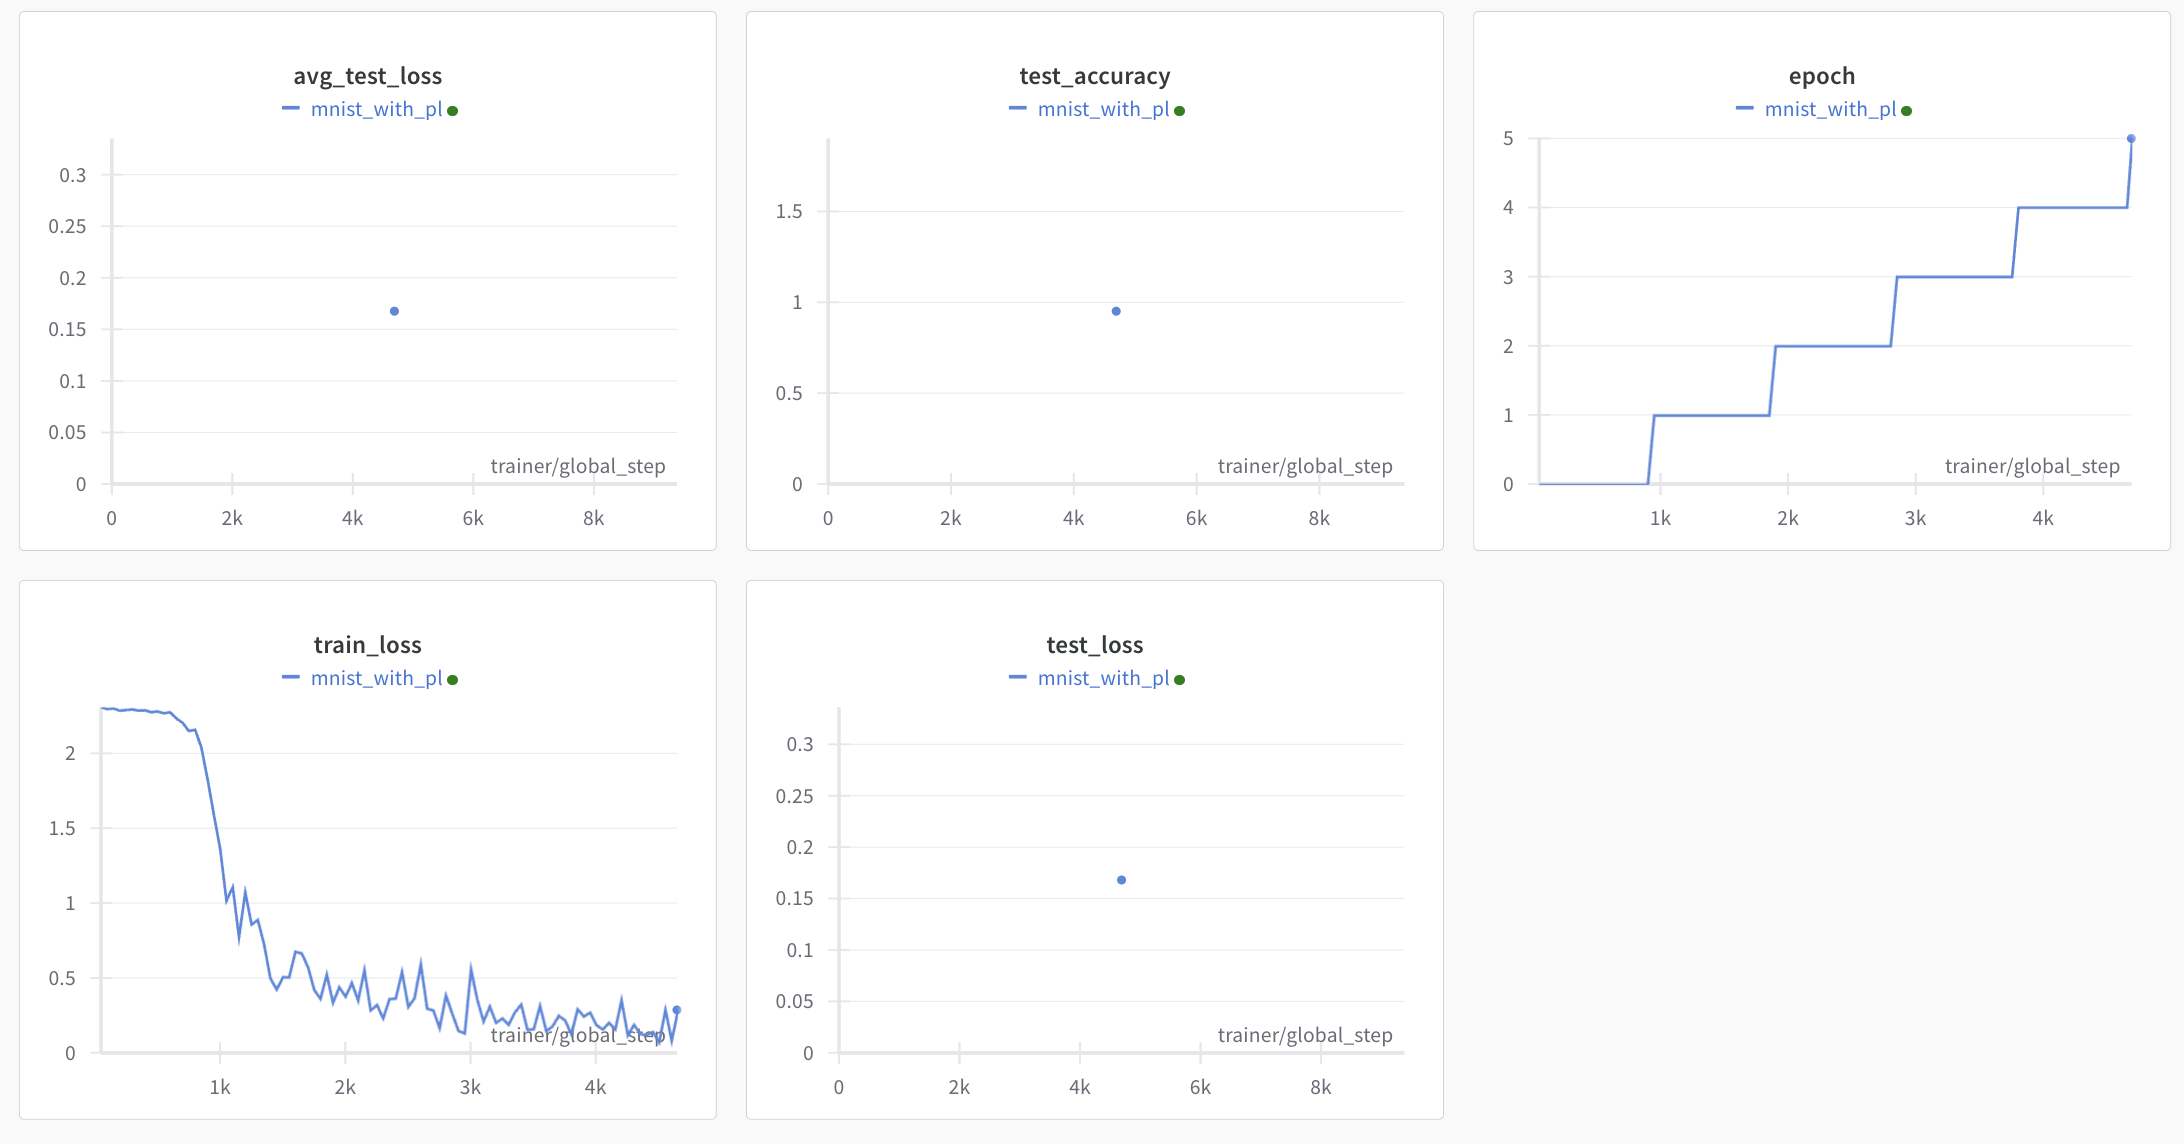